<a href="https://colab.research.google.com/github/lgwolmer/BootCamp_Enap_2021/blob/main/Tempestividade_do_julgamento_de_autos_de_infracao_Ibama_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Bootcamp ML Enap 2021

Desenvolvimento do projeto de construção de um modelo preditivo para classificação de autos de infração do Ibama por tempestividade da instrução/julgamento.

Os dados são disponibilizados originalmente em https://dados.gov.br/dataset/volume-de-julgamento-de-auto-de-infracao e já foi realizada uma limpeza e preparação inicial, incluindo a anonimização dos dados em relação aos infratores.

Neste caderno é desenvolvido o modelo preditivo a partir dos dados anonimizados constantes em /content/drive/MyDrive/Colab Notebooks/bootcamp/dados/dados_anonimizados_autos_infracao.csv.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importar bibliotecas e recuperar dados

In [ ]:
# Importação das bibliotecas necessárias
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
import pandas as pd
import datetime as dt

from pathlib import Path

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix 

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
from sklearn import metrics

from scipy import stats as ss
import numpy as np

#Configurações gerais
%matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 200
figsize = (12,9)
pd.options.display.float_format = '{:.2f}'.format

# color backgroud
color_bg = 'rgba(0,0,0,0)'

In [ ]:
# instalação da biblioteca para visualização de árvores de decisão
!pip install dtreeviz

     |████████████████████████████████| 62 kB 690 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.2-py3-none-any.whl size=67936 sha256=76c886f59a88c35c0087c27e5dac94a064f1c0746f83439535518255bf5865c3
  Stored in directory: /root/.cache/pip/wheels/9d/29/a1/f2ad20de79875e749330d5c6234fc5f517991fcaa23d7a3d0f
Successfully built dtreeviz


# Carga dos dados anonimizados 

In [ ]:
df_bruto = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bootcamp/dados/dados_anonimizados_autos_infracao.csv', parse_dates = ['DT_JULGAMENTO_PRINCIPAL','DT_JULGAMENTO_RECURSO',
                                                                          'DT_AUTO','DT_PAGAMENTO', 'DT_ATUALIZACAO'], index_col=None)

# EDA


In [ ]:
df_bruto.dtypes

Unnamed: 0                          int64
UF                                 object
MUN                                object
STATUS_DEBITO                      object
DECISAO_ADM                        object
TIPO_AUTO                          object
TIPO_INFRACAO                      object
ENQUADRAMENTO                      object
DT_JULGAMENTO_PRINCIPAL    datetime64[ns]
DT_JULGAMENTO_RECURSO      datetime64[ns]
DT_AUTO                    datetime64[ns]
VALOR_AUTO                        float64
MOEDA                              object
VL_PAGO                           float64
DT_PAGAMENTO               datetime64[ns]
DT_ATUALIZACAO             datetime64[ns]
TIPO_PESSOA                        object
dtype: object

In [ ]:
# Quantidade de registros 
df_bruto.count()

Unnamed: 0                 235855
UF                         235855
MUN                        235855
STATUS_DEBITO              235855
DECISAO_ADM                 14908
TIPO_AUTO                  235612
TIPO_INFRACAO              235612
ENQUADRAMENTO              112940
DT_JULGAMENTO_PRINCIPAL    147656
DT_JULGAMENTO_RECURSO       40115
DT_AUTO                    235612
VALOR_AUTO                 235612
MOEDA                      235612
VL_PAGO                    235612
DT_PAGAMENTO               235607
DT_ATUALIZACAO             235612
TIPO_PESSOA                235855
dtype: int64

## Variáveis que não serão utilizadas

** As colunas STATUS_DÉBITO e DECISAO_ADM  não serão levadas em conta neste projeto porque essas variáveis não influem na definição da tempestividade da etapa do contencioso, ou seja, nos tempos decorridos para eventual instrução/julgamento de defesa e/ou recurso pelo Ibama.
A tempestividade é calculada com base no prazo decorrido para ocorrer o julgamento principal, ou de recurso (se houver).
Assim, interessam para definição desse "target" apenas as datas de julgamento principal e de recurso, quando existentes, e a data da lavratura do auto, conforme regra de negócio explicitada adiante.
Em relação à capacidade de predição serão examinadas outras variáveis independentes à continuação, mas STATUS_DÉBITO e DECISAO_ADM, em que pese definirem a situação do auto de infração no momento, não interferem nos tempos decorridos na etapa do contecioso, objeto do presente estudo.


# Verificação da existência e da consistência das datas dos julgamentos

In [ ]:
# Verificação de inconsistências entre as datas de julgamento principal e de recurso. A rigor a data do julgamento do recurso teria
# que ser maior (mais recente) do que a data do julgamento principal. Foram detectados 6350 registros fora dessa situação e que serão deletados.
df_bruto[~(df_bruto.DT_JULGAMENTO_PRINCIPAL.isna()) & ~(df_bruto.DT_JULGAMENTO_RECURSO.isna()) & (df_bruto.DT_JULGAMENTO_RECURSO < df_bruto.DT_JULGAMENTO_PRINCIPAL) ].count()

Unnamed: 0                 6350
UF                         6350
MUN                        6350
STATUS_DEBITO              6350
DECISAO_ADM                 489
TIPO_AUTO                  6350
TIPO_INFRACAO              6350
ENQUADRAMENTO              3829
DT_JULGAMENTO_PRINCIPAL    6350
DT_JULGAMENTO_RECURSO      6350
DT_AUTO                    6350
VALOR_AUTO                 6350
MOEDA                      6350
VL_PAGO                    6350
DT_PAGAMENTO               6348
DT_ATUALIZACAO             6350
TIPO_PESSOA                6350
dtype: int64

In [ ]:
# Verificação de registros sem data de julgamento principal e sem data de julgamento de recurso.
# Foram detectados 84.134 registros nessa situação, indicando que não houve instrução/julgamento de defesa e/ou recurso, e que serão então deletados, 
# pois se está buscando conhecer prazos da etapa do contecioso (quando houve), e os casos em que não foram apresentados defesas e/ou recursos estão fora do escopo.
df_bruto[(df_bruto.DT_JULGAMENTO_PRINCIPAL.isna()) & (df_bruto.DT_JULGAMENTO_RECURSO.isna())].count()

Unnamed: 0                 84134
UF                         84134
MUN                        84134
STATUS_DEBITO              84134
DECISAO_ADM                 5734
TIPO_AUTO                  83891
TIPO_INFRACAO              83891
ENQUADRAMENTO              27973
DT_JULGAMENTO_PRINCIPAL        0
DT_JULGAMENTO_RECURSO          0
DT_AUTO                    83891
VALOR_AUTO                 83891
MOEDA                      83891
VL_PAGO                    83891
DT_PAGAMENTO               83891
DT_ATUALIZACAO             83891
TIPO_PESSOA                84134
dtype: int64

In [ ]:
# exclusão de registros com inconsistência nas datas de julgamento ou com ambas as datas vazias
dfx = df_bruto[~ (~(df_bruto.DT_JULGAMENTO_PRINCIPAL.isna()) & ~(df_bruto.DT_JULGAMENTO_RECURSO.isna()) & (df_bruto.DT_JULGAMENTO_RECURSO < df_bruto.DT_JULGAMENTO_PRINCIPAL)
      | (df_bruto.DT_JULGAMENTO_PRINCIPAL.isna()) & (df_bruto.DT_JULGAMENTO_RECURSO.isna()) )]

Obs: restaram registros com data de julgamento de recurso preenchida, mas sem data de julgamento principal. Foram considerados válidos para efeito desta análise porque está sendo avaliada a tempestividade da instrução/julgamento de 1ª e 2ª instância. Ou seja, está se assumindo que o julgamento de recurso sinaliza que houve contencioso, mesmo que não conste, nos dados disponíveis, a indicação da data do julgamento principal, de 1ª instância.

## Estabelecimento de um escopo temporal para o modelo. Foram considerados registros de infrações ambientais com data de autuação a partir de 2010.

In [ ]:
# limitando dados para autos de infração lavrados a partir de 2010
df=dfx[dfx.DT_AUTO > '2009-12-31']

In [ ]:
df.count()

Unnamed: 0                 32826
UF                         32826
MUN                        32826
STATUS_DEBITO              32826
DECISAO_ADM                 1271
TIPO_AUTO                  32826
TIPO_INFRACAO              32826
ENQUADRAMENTO              32823
DT_JULGAMENTO_PRINCIPAL    31151
DT_JULGAMENTO_RECURSO      10933
DT_AUTO                    32826
VALOR_AUTO                 32826
MOEDA                      32826
VL_PAGO                    32826
DT_PAGAMENTO               32826
DT_ATUALIZACAO             32826
TIPO_PESSOA                32826
dtype: int64

# Verificação da proporção entre PF e PJ

In [ ]:
print ('Total de registros: ', df['TIPO_PESSOA'].count())
print (df['TIPO_PESSOA'].value_counts())
df['TIPO_PESSOA'].value_counts(normalize=True)

Total de registros:  32826
Pessoa Jurídica    17750
Pessoa Física      15076
Name: TIPO_PESSOA, dtype: int64


Pessoa Jurídica   0.54
Pessoa Física     0.46
Name: TIPO_PESSOA, dtype: float64

# Definição da Variável Dependente: Tempestividade da Instrução/Julgamento

--> O prazo decorrido para julgamento (principal ou recurso) tem que ser menor que 360 dias para que a etapa do contecioso (instrução/julgamento em 1ª e/ou 2ª instância) seja considerado tempestiva.

Se  DT_JULGAMENTO_RECURSO preenchida (houve julgamento de recurso – 2ª instância)
   Então Tempestividade do contencioso (Sim/Não) = (DT_JULGAMENTO_RECURSO menos (DT_AUTO mais 80 dias)) menor ou igual a 360 dias
    
  Senão 
           Se DT_JULGAMENTO PRINCIPAL preenchida (houve julgamento inicial – 1ª instância)
              Então Tempestividade do contencioso (Sim/Não) = (DT_JULGAMENTO_PRINCIPAL menos (DT_AUTO mais 80 dias) ) menor ou igual a 360 dias;

Obs: Como não consta nos dados ora disponíveis a data de início da instrução (de análise da defesa), foi então estimado um prazo típico de 80 dias decorridos entre a data de lavratura do auto de infração e a data de início da instrução, a partir dos prazos normatizados para tentativa de conciliação e notificação dos infratores.

In [ ]:
from datetime import datetime, timedelta

In [ ]:
# Rotina para definir o atributo "TEMPESTIVIDADE": 0 = NÃO; 1 = SIM

def definir_TEMPESTIVIDADE(data_julg_principal, data_julg_recurso, data_auto):
    if ~(data_julg_recurso == ''):
            if (data_julg_recurso - (data_auto + timedelta(days=80)) <= timedelta(days=360)):
                 return 1
            else:
                if ~(data_julg_principal == ''):
                    if (data_julg_principal - (data_auto + timedelta(days=80)) <= timedelta(days=360)):
                        return 1
                    else:
                        return 0
    else:
        return 0

In [ ]:
# Criação da nova coluna com a variável dependente
df['TEMPESTIVIDADE'] = df.apply(lambda row:definir_TEMPESTIVIDADE(row.DT_JULGAMENTO_PRINCIPAL,row.DT_JULGAMENTO_RECURSO,row.DT_AUTO), axis = 1) 

Total de registros:  32826
0    22174
1    10652
Name: TEMPESTIVIDADE, dtype: int64
0   0.68
1   0.32
Name: TEMPESTIVIDADE, dtype: float64


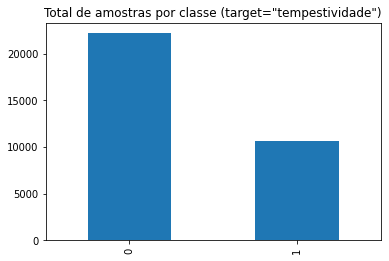

In [ ]:
# Verificação do balanço entre classes da variável dependente
print ('Total de registros: ', df['TEMPESTIVIDADE'].count())
print ( df['TEMPESTIVIDADE'].value_counts())
print (df['TEMPESTIVIDADE'].value_counts(normalize=True))
df.TEMPESTIVIDADE.value_counts().plot(kind='bar', title='Total de amostras por classe (target="tempestividade")');

Verificação da quantidade de autos de infração por ano

In [ ]:
# cria coluna com o ano da lavratura do auto
df['ANO_AUTO'] = df.apply(lambda row:row.DT_AUTO.year, axis = 1)

In [ ]:
# verifica quantidade de autos por ano. Percebida diminuição nos últimos dois anos que se mostra plausível, 
# considerando o histórico de longos prazos de instrução/julgamento
df.groupby('ANO_AUTO')['TEMPESTIVIDADE'].count().reset_index().sort_values('ANO_AUTO')


,ANO_AUTO,TEMPESTIVIDADE
0,2010,5471
1,2011,5193
2,2012,4669
3,2013,3710
4,2014,3072
5,2015,3571
6,2016,3277
7,2017,2075
8,2018,1468
9,2019,318


## Avaliação e escolha/construção das possíveis variáveis independentes 

   

In [ ]:
# Tipo de auto de infração
# Contém 3 categorias
print (df.TIPO_AUTO.unique())
df.TIPO_AUTO.value_counts()

['Multa' 'Multa DiÃ¡ria' 'Advertencia']


Multa            32795
Multa DiÃ¡ria       28
Advertencia          3
Name: TIPO_AUTO, dtype: int64

In [ ]:
# Tipo de Infração
print (df.TIPO_INFRACAO.unique())
df.TIPO_INFRACAO.value_counts()
# Contém 10 categorias
# Obs: o Tipo de Infração "Ecosistema" somente tem 3 ocorrências ....

['Controle ambiental' 'Cadastro Técnico Federal'
 'Org. Gen. Modific. e Biopirataria' 'Flora' 'Pesca' 'Outras' 'Fauna'
 'Ordenamento urbano e Contr. patrim.' 'Unidades de conservação'
 'Ecossistema']


Cadastro Técnico Federal               9520
Flora                                  7403
Controle ambiental                     5582
Fauna                                  5250
Pesca                                  3010
Outras                                 1480
Org. Gen. Modific. e Biopirataria       451
Ordenamento urbano e Contr. patrim.      87
Unidades de conservação                  40
Ecossistema                               3
Name: TIPO_INFRACAO, dtype: int64

In [ ]:
# Enquadramento (legal) do auto de infração
print (df.ENQUADRAMENTO.unique())
len(df.ENQUADRAMENTO.unique())
# contém mais de 2400 categorias !
# No resumo adiante será feita a avaliação detalhada da viabilidade de uso desta variável 

['Lei 9605/98 - Artigo 70, Decreto 6514/2008 - Artigo 66, Lei 6938/81 - Artigo 10'
 'Lei 9605/98 - Artigo 70, Lei Lei 9.605/98 - Artigo 3'
 'Decreto 6514/2008 - Artigo 3, Lei 9605/98 - Artigo 70' ...
 'Lei 9605/98 - Artigo 70, Decreto 6514/2008 - Artigo 3°,  Constituição Federal - Artigo 1°'
 'Lei 9605/98 - Artigo 70, Decreto 6514/2008 - Artigo 50, Decreto 6514/2008 - Artigo 3°'
 'Lei 9605/98 - Artigo 70, Decreto 6514/2008 - Artigo 3°, Instrução Normativa Ibama 112/2006 - Artigo 2°']


2482

In [ ]:
df.ENQUADRAMENTO.value_counts()

Lei 9605/98 - Artigo 70, Decreto 6514/2008 - Artigo 3                                                   10666
Lei 9605/98 - Artigo 70, Decreto 6514/2008 - Artigo 3º                                                   5593
Lei 9605/98 - Artigo 70, Decreto 6514/2008 - Artigo 24                                                   1310
Decreto 6514/2008 - Artigo 3, Lei 9605/98 - Artigo 70                                                    1013
Decreto 6514/2008 - Artigo 3º, Lei 9605/98 - Artigo 70                                                    701
                                                                                                        ...  
Lei 9605/98 - Artigo 70, Decreto 6514/2008 - Artigo 3, Decreto Decreto - Artigo 30                          1
Lei 9605/98 - Artigo 60, Decreto 6514/2008 - Artigo 3                                                       1
Lei 9605/98 - Artigo 70/72, Decreto 6514/2008 - Artigo 3º, Lei 4771/65 - Artigo 2°                          1
Decreto 65

In [ ]:
df[df.ENQUADRAMENTO.isna()]

,Unnamed: 0,UF,MUN,STATUS_DEBITO,DECISAO_ADM,TIPO_AUTO,TIPO_INFRACAO,ENQUADRAMENTO,DT_JULGAMENTO_PRINCIPAL,DT_JULGAMENTO_RECURSO,DT_AUTO,VALOR_AUTO,MOEDA,VL_PAGO,DT_PAGAMENTO,DT_ATUALIZACAO,TIPO_PESSOA,TEMPESTIVIDADE,ANO_AUTO
30624,34346,SC,INDAIAL,Quitado. Baixa automática,NaN,Multa,Cadastro Técnico Federal,NaN,2013-05-27,NaT,2011-08-09,10000.00,Real,16438.80,2013-10-17,2021-08-09 19:10:00,Pessoa Física,0,2011
32322,36054,SC,SANTO AMARO DA IMPERATRIZ,Quitado. Baixa automática,NaN,Multa,Fauna,NaN,2013-01-15,NaT,2011-09-05,1000.00,Real,821.40,2013-04-23,2021-08-09 19:10:00,Pessoa Física,0,2011
226457,234983,AM,ALVARAES,Excluído,Excluir débito,Multa,Outras,NaN,2009-05-15,2012-01-11,2017-06-03,111.10,Real,12691.40,2014-10-31,2021-08-09 19:00:00,Pessoa Física,1,2017


In [ ]:
# cria coluna com o mês da lavratura do auto, considerando a possibilidade de haver algum efeito sazonal vinculado ao período do ano da autuação
# No formato string para poder ser codificado, uma vez que se trata de dado categórico para este contexto
df['MES_AUTO'] = df.apply(lambda row:row.DT_AUTO.month, axis = 1).astype(str)

In [ ]:
df['MES_AUTO'] = df['MES_AUTO'].replace(['1', '2', '3', '4', '5', '6','7','8','9'],['01','02','03','04','05','06','07','08','09'])

In [ ]:
# verifica quantidade de autos por mês do ano em que foi realizada a lavratura do AI
df.groupby('MES_AUTO')['TEMPESTIVIDADE'].count().reset_index().sort_values('MES_AUTO')


,MES_AUTO,TEMPESTIVIDADE
0,01,1991
1,02,2467
2,03,3263
3,04,2726
4,05,2947
5,06,2782
6,07,2505
7,08,3086
8,09,2904
9,10,2902


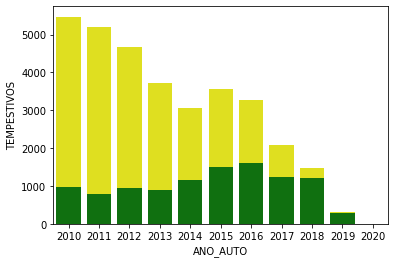

In [ ]:
# Tempestividade vs ANO_AUTO
# Observa-se que a tempestividade vem melhorando nos últimos anos
aux1 = df[['ANO_AUTO', 'TEMPESTIVIDADE']].groupby('ANO_AUTO').count().reset_index()
aux2 = df[['ANO_AUTO', 'TEMPESTIVIDADE']].groupby('ANO_AUTO').sum().reset_index()
aux1['TEMPESTIVOS'] = aux2['TEMPESTIVIDADE']
s1 = sns.barplot (x='ANO_AUTO', y='TEMPESTIVIDADE', data=aux1, color='yellow');
s2 = sns.barplot (x='ANO_AUTO', y='TEMPESTIVOS', data=aux1, color='green');

In [ ]:
# Verifica a distribuição de infrações por UF
print(df.UF.unique())
df.UF.value_counts()

['TO' 'SE' 'SP' 'SC' 'RR' 'RO' 'RS' 'RN' 'RJ' 'PI' 'PE' 'PR' 'PB' 'PA'
 'MG' 'MS' 'MT' 'MA' 'GO' 'ES' 'DF' 'CE' 'BA' 'AM' 'AP' 'AL' 'AC']


CE    3644
SP    3341
ES    2384
PB    2330
PR    1975
TO    1896
RS    1824
MS    1777
SC    1427
BA    1310
MG    1136
GO    1077
PI    1034
PE     989
PA     944
RJ     848
MT     678
RN     669
RO     645
MA     622
AL     554
AM     528
DF     368
RR     315
AP     223
AC     145
SE     143
Name: UF, dtype: int64

count      32826.00
mean       15589.96
std       323355.70
min           40.00
25%         1500.00
50%         3500.00
75%        10000.00
max     50000000.00
Name: VALOR_AUTO, dtype: float64


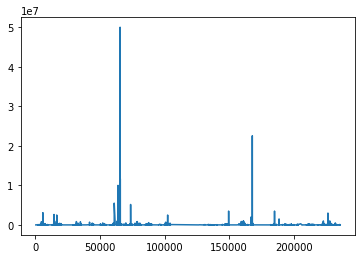

In [ ]:
# verifica variabilidade do VALOR_AUTO
print(df.VALOR_AUTO.describe())
df.VALOR_AUTO.plot();

In [ ]:
# Rotina para definir a variável "FAIXA_VALOR_AUTO" - categórica    - Varia de 1 a 4, de acordo com o quartil:
#                                 1 - <= 1500.00
#                                 2 - <= 3500.00
#                                 3 - <= 10000.00
#                                 4 - > 10.000
                                  
def definir_FAIXA_VALOR_AUTO(valor):
    if valor <= 1500:
        return '1'
    else:
      if valor <= 3500:
        return '2'
      else:
        if valor <= 10000:
          return '3'
        else:
          return '4'

In [ ]:
# Criação da nova coluna para faixa de valor dos autos de infração, com base nos quartis identificados
df['FAIXA_VALOR_AUTO'] = df.apply(lambda row:definir_FAIXA_VALOR_AUTO(row.VALOR_AUTO), axis = 1) 

In [ ]:
# Verifica a distribuição de infrações por faixa de valor
print(df.FAIXA_VALOR_AUTO.unique())
df.FAIXA_VALOR_AUTO.value_counts()

['3' '1' '4' '2']


3    10055
1     9599
2     7004
4     6168
Name: FAIXA_VALOR_AUTO, dtype: int64

# Definição das variáveis independentes

    TIPO_PESSOA - categórica  - "Pessoa física" ou "Pessoa jurídica"
    
    UF         - categórica  - 27 categorias    

    MUNICÍPIO  -                   (* NÃO INCLUÍDA por ser entedida como não
                                   determinante da tempestividade e também
                                   aumentaria muito as dimensões do modelo *)
    STATUS_DÉBITO e DECISAO_ADM -  (* NÃO INCLUÍDAS  neste projeto porque
                                     não influem na definição da tempestividade
                                     da etapa do contencioso, ou seja, nos
                                     tempos decorridos para eventual instrução/
                                    julgamento de defesa e/ou recurso.
                                    
    
    TIPO_AUTO   - categórica  - 03 categorias (* ocorrência predominante de 'multa'-99,9% (32804)
                                                 dos registros - NÃO INCLUÍDA*)
                                              
    TIPO_INFRACAO - categórica - 10 categorias: (* 'Controle ambiental' 'Cadastro Técnico Federal'
                                                'Org. Gen. Modific. e Biopirataria' 'Flora' 'Pesca'
                                                'Outras' 'Fauna' 'Ordenamento urbano e Contr
                                                .patrim.''Unidades de conservação' 'Ecossistema' *)
    ENQUADRAMENTO - categórica  - 2482 categorias (* NÃO INCLUÍDA - detectada fragmentação por erro 
                                  de grafia - ex: 'Lei 9605/98 - Artigo 70,Decreto 6514/2008 -
                                  Artigo 3': 10669 ocorrências; e 'Lei 9605/98 - Artigo 70, Decreto
                                  6514/2008 Artigo 3º': 5595 ocorrências.
                                  Se reconstituída essa categoria, representaria 49% (16264/32835)
                                  dos registros*) - ainda há 3 regsistros com ENQUADRAMENTO vazio.
                                  
                                  (* ao pesquisar esses dispostivos verifica-se que são genéricos:
                                     Art. 70. da Lei 9605/98 - Considera-se infração administrativa
                                     ambiental toda ação/ omissão que viole as regras jurídicas de 
                                     uso, gozo, promoção, proteção e recuperação do meio ambiente.
                                     Art. 3o  do Decreto 6514/2008 - As infrações administrativas
                                     são punidas com as seguintes sanções: I - advertência; 
                                     II - multa simples; III - multa diária; ... 
                                     
                                     Apesar do enquadramento parecer ser um preditor potencial para 
                                     duração da análise/julgamento, da forma como está disponível,
                                     com fragmentação e conteúdo genérico, NÃO será incluído    *)
                                     
    MES_AUTO   - categórica -       12 categorias (01 a 12) - Mês em que ocorreu a lavratura do
                                        auto. 
                                     (* Propõe-se incluir pela possibilidade de haver alguma
                                        sazonalidade que afete a eficiência do processo de 
                                        instrução/julgamento *)
                                     
    VALOR_AUTO - numérica    -      Varia de 40,00 a 5o milhões de reais. Média=15.586 e Desvio
                                    Padrão=323.311; Mediana = 3.500.  Foi aplicada normalização e incluída no modelo.
                                     Mas até diminuiu um pouco a acurácia. (* NÂO INCLUÍDA tendo sido decidido
                                     trabalhar com faixas de valores de acordo com o quartil.

                                     
    FAIXA_VALOR_AUTO - categórica    - Varia de 1 a 4, de acordo com o quartil:
                                       1 - <= 1500.00
                                       2 - <= 3500.00
                                       3 - <= 10000.00
                                       4 - > 10.000

## Análise adicional das variáveis independentes escolhidas (todas categóricas): 
TIPO_PESSOA , UF, TIPO_INFRACAO, MES_AUTO, FAIXA_VALOR_AUTO



In [ ]:
# atribuir os valores das variáveis independentes a 'X_base'
X_base = df[['TIPO_PESSOA', 'UF', 'TIPO_INFRACAO', 'MES_AUTO', 'FAIXA_VALOR_AUTO']]
# atribuir os valores da variável dependente a 'y'
y = df.TEMPESTIVIDADE
# Mostrar as dimensões de X_base e y
print('Dimensões de X_base = ', X_base.shape)
print('Dimensões de y = ', y.shape)

Dimensões de X_base =  (32826, 5)
Dimensões de y =  (32826,)


Análise do relacionamentos entre as variáveis independentes e o "target"


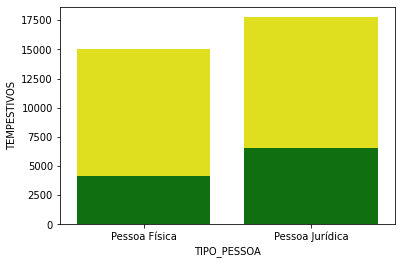

In [ ]:
# Tempestividade vs TIPO_PESSOA
aux1 = df[['TIPO_PESSOA', 'TEMPESTIVIDADE']].groupby('TIPO_PESSOA').count().reset_index()
aux2 = df[['TIPO_PESSOA', 'TEMPESTIVIDADE']].groupby('TIPO_PESSOA').sum().reset_index()
aux1['TEMPESTIVOS'] = aux2['TEMPESTIVIDADE']
s1 = sns.barplot (x='TIPO_PESSOA', y='TEMPESTIVIDADE', data=aux1, color='yellow');
s2 = sns.barplot (x='TIPO_PESSOA', y='TEMPESTIVOS', data=aux1, color='green');

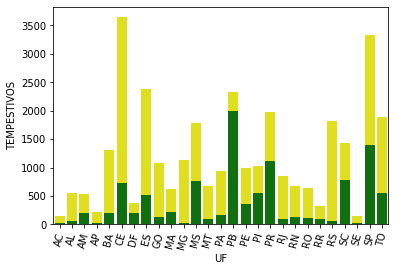

In [ ]:
# Tempestividade vs UF
aux1 = df[['UF', 'TEMPESTIVIDADE']].groupby('UF').count().reset_index()
aux2 = df[['UF', 'TEMPESTIVIDADE']].groupby('UF').sum().reset_index()
aux1['TEMPESTIVOS'] = aux2['TEMPESTIVIDADE']
plt.xticks(rotation=75)
s1 = sns.barplot (x='UF', y='TEMPESTIVIDADE', data=aux1, color='yellow');
s2 = sns.barplot (x='UF', y='TEMPESTIVOS', data=aux1, color='green');


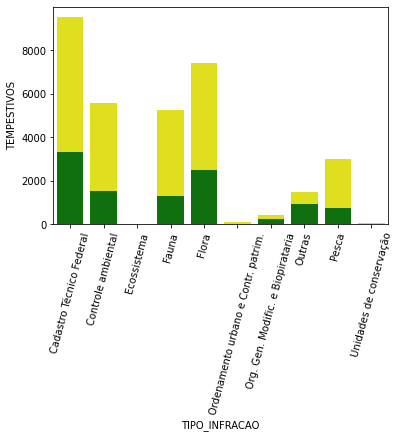

In [ ]:
# Tempestividade vs TIPO_INFRACAO
aux1 = df[['TIPO_INFRACAO', 'TEMPESTIVIDADE']].groupby('TIPO_INFRACAO').count().reset_index()
aux2 = df[['TIPO_INFRACAO', 'TEMPESTIVIDADE']].groupby('TIPO_INFRACAO').sum().reset_index()
aux1['TEMPESTIVOS'] = aux2['TEMPESTIVIDADE']
plt.xticks(rotation=75)
s1 = sns.barplot (x='TIPO_INFRACAO', y='TEMPESTIVIDADE', data=aux1, color='yellow');
s2 = sns.barplot (x='TIPO_INFRACAO', y='TEMPESTIVOS', data=aux1, color='green');

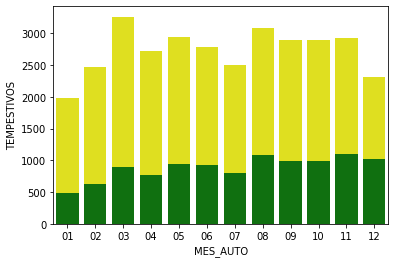

In [ ]:
# Tempestividade vs MES_AUTO
aux1 = df[['MES_AUTO', 'TEMPESTIVIDADE']].groupby('MES_AUTO').count().reset_index()
aux2 = df[['MES_AUTO', 'TEMPESTIVIDADE']].groupby('MES_AUTO').sum().reset_index()
aux1['TEMPESTIVOS'] = aux2['TEMPESTIVIDADE']
#plt.xticks(rotation=75)
aux1.sort_values(by=['MES_AUTO'], ascending=True, inplace=True)
s1 = sns.barplot (x='MES_AUTO', y='TEMPESTIVIDADE', data=aux1, color='yellow');
s2 = sns.barplot (x='MES_AUTO', y='TEMPESTIVOS', data=aux1, color='green');

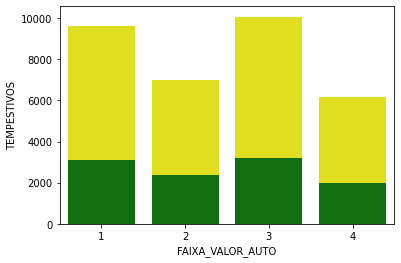

In [ ]:
# Tempestividade vs FAIXA_VALOR_AUTO
aux1 = df[['FAIXA_VALOR_AUTO', 'TEMPESTIVIDADE']].groupby('FAIXA_VALOR_AUTO').count().reset_index()
aux2 = df[['FAIXA_VALOR_AUTO', 'TEMPESTIVIDADE']].groupby('FAIXA_VALOR_AUTO').sum().reset_index()
aux1['TEMPESTIVOS'] = aux2['TEMPESTIVIDADE']
#plt.xticks(rotation=75)
aux1.sort_values(by=['FAIXA_VALOR_AUTO'], ascending=True, inplace=True)
s1 = sns.barplot (x='FAIXA_VALOR_AUTO', y='TEMPESTIVIDADE', data=aux1, color='yellow');
s2 = sns.barplot (x='FAIXA_VALOR_AUTO', y='TEMPESTIVOS', data=aux1, color='green');

Análise do relacionamentos entre as todas as variáveis independentes e a variável dependente (por V de Cramer, aplicável a variáveis categóricas)

In [ ]:
# função para calcular o V de Cramer
def cramer_v (x, y):
    cm = pd.crosstab (x,y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency (cm)[0]
    
    # correct bias
    chi2corr = max (0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) **2/(n-1)
    rcorr = r - (r-1) **2/(n-1)
    
    return np.sqrt((chi2corr/n) /(min (kcorr-1, rcorr-1)) )

In [ ]:
# separa todas as variáveis categóricas escolhidas
a = df[['TIPO_PESSOA' , 'UF', 'TIPO_INFRACAO', 'MES_AUTO', 'FAIXA_VALOR_AUTO', 'TEMPESTIVIDADE']]

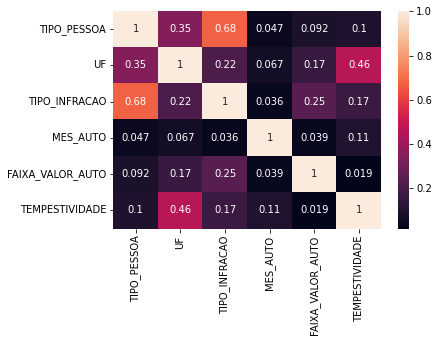

In [ ]:
a1 = cramer_v (a['TIPO_PESSOA'], a['TIPO_PESSOA'])
a2 = cramer_v (a['TIPO_PESSOA'], a['UF'])
a3 = cramer_v (a['TIPO_PESSOA'], a['TIPO_INFRACAO'])
a4 = cramer_v (a['TIPO_PESSOA'], a['MES_AUTO'])
a5 = cramer_v (a['TIPO_PESSOA'], a['FAIXA_VALOR_AUTO'])
a6 = cramer_v (a['TIPO_PESSOA'], a['TEMPESTIVIDADE'])

a7 = cramer_v (a['UF'], a['TIPO_PESSOA'])
a8 = cramer_v (a['UF'], a['UF'])
a9 = cramer_v (a['UF'], a['TIPO_INFRACAO'])
a10 = cramer_v (a['UF'], a['MES_AUTO'])
a11 = cramer_v (a['UF'], a['FAIXA_VALOR_AUTO'])
a12 = cramer_v (a['UF'], a['TEMPESTIVIDADE'])

a13 =  cramer_v (a['TIPO_INFRACAO'], a['TIPO_PESSOA'])
a14 = cramer_v (a['TIPO_INFRACAO'], a['UF'])
a15 = cramer_v (a['TIPO_INFRACAO'], a['TIPO_INFRACAO'])
a16 = cramer_v (a['TIPO_INFRACAO'], a['MES_AUTO'])
a17 = cramer_v (a['TIPO_INFRACAO'], a['FAIXA_VALOR_AUTO'])
a18 = cramer_v (a['TIPO_INFRACAO'], a['TEMPESTIVIDADE'])

a19 = cramer_v (a['MES_AUTO'], a['TIPO_PESSOA'])
a20 = cramer_v (a['MES_AUTO'], a['UF'])
a21 = cramer_v (a['MES_AUTO'], a['TIPO_INFRACAO'])
a22 = cramer_v (a['MES_AUTO'], a['MES_AUTO'])
a23 = cramer_v (a['MES_AUTO'], a['FAIXA_VALOR_AUTO'])
a24 = cramer_v (a['MES_AUTO'], a['TEMPESTIVIDADE'])

a25 = cramer_v (a['FAIXA_VALOR_AUTO'], a['TIPO_PESSOA'])
a26 = cramer_v (a['FAIXA_VALOR_AUTO'], a['UF'])
a27 = cramer_v (a['FAIXA_VALOR_AUTO'], a['TIPO_INFRACAO'])
a28 = cramer_v (a['FAIXA_VALOR_AUTO'], a['MES_AUTO'])
a29 = cramer_v (a['FAIXA_VALOR_AUTO'], a['FAIXA_VALOR_AUTO'])
a30 = cramer_v (a['FAIXA_VALOR_AUTO'], a['TEMPESTIVIDADE'])

a31 = cramer_v (a['TEMPESTIVIDADE'], a['TIPO_PESSOA'])
a32 = cramer_v (a['TEMPESTIVIDADE'], a['UF'])
a33 = cramer_v (a['TEMPESTIVIDADE'], a['TIPO_INFRACAO'])
a34 = cramer_v (a['TEMPESTIVIDADE'], a['MES_AUTO'])
a35 = cramer_v (a['TEMPESTIVIDADE'], a['FAIXA_VALOR_AUTO'])
a36 = cramer_v (a['TEMPESTIVIDADE'], a['TEMPESTIVIDADE'])


d = pd.DataFrame ( {'TIPO_PESSOA': [a1, a2, a3, a4, a5, a6],
                'UF': [a7, a8, a9, a10, a11, a12],
                'TIPO_INFRACAO': [a13, a14, a15, a16, a17, a18],
                'MES_AUTO' : [a19, a20, a21, a22, a23, a24],
                'FAIXA_VALOR_AUTO' : [a25, a26, a27, a28, a29, a30],
                'TEMPESTIVIDADE' : [a31, a32, a33, a34, a35, a36]
                 })
# column names as indexes
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)


## 1a rodada de testes - codificação das variáveis independentes  - primeiramente com label encoding

In [ ]:
# Antes de dividir os dados entre treinamento e teste, codificar tudo, pois são todas categóricas
# Se codificar após dividir pode haver falta de alguma categoria minoritária em uma das duas partes

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X = X_base.apply(le.fit_transform)


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32826 entries, 397 to 235825
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   TIPO_PESSOA       32826 non-null  int64
 1   UF                32826 non-null  int64
 2   TIPO_INFRACAO     32826 non-null  int64
 3   MES_AUTO          32826 non-null  int64
 4   FAIXA_VALOR_AUTO  32826 non-null  int64
dtypes: int64(5)
memory usage: 1.5 MB


## Fazer balanceamento das classes com SMOTE

In [ ]:

#!pip install imbalanced-learn

In [ ]:
#import imblearn
#from imblearn.over_sampling import SMOTE

In [ ]:
#oversample = over_sampling.SMOTE()
#X, y = oversample.fit_resample(X, y)

In [ ]:
#X.value_counts()


In [ ]:
# Dividir o dataset entre treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, stratify = y)
print('Dimensões de X_train = ', X_train.shape)
print('Dimensões de X_test = ', X_test.shape)

Dimensões de X_train =  (26260, 5)
Dimensões de X_test =  (6566, 5)


In [ ]:
print('Amostras de treino= ', y_train.shape)
y_train.value_counts()

Amostras de treino=  (26260,)


0    17739
1     8521
Name: TEMPESTIVIDADE, dtype: int64

In [ ]:
print('Amostras de teste= ', y_test.shape)
y_test.value_counts()

Amostras de teste=  (6566,)


0    4435
1    2131
Name: TEMPESTIVIDADE, dtype: int64

## Treinamento do Modelo - Regressão Logística

In [ ]:
# Instanciar modelo de regressão logística
reg_log = LogisticRegression(max_iter=1000)

In [ ]:
# Treinar o modelo
reg_log.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Verificar a acurácia do modelo (.score)

reg_log.score(X_test, y_test)

0.6727078891257996

In [ ]:
# Verificar o f1_score do modelo, quando as classes estão desbalenceadas, lembrando de usar dados de teste codificados
metrics.f1_score(y_test, reg_log.predict(X_test), average='weighted')

0.5744633721719777

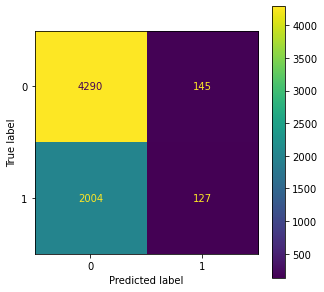

In [ ]:
# Mostrar a Matriz de Confusão 
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(reg_log, X_test, y_test, ax=ax, values_format='d');

## Treinamento do Modelo - KNN

In [ ]:
# Importar o modelo knn
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Instanciar modelo de regressão logística
knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
# Treinar o modelo
knn.fit(X_train, y_train)


KNeighborsClassifier()

In [ ]:

# Verificar a acurácia do modelo (.score)
knn.score(X_test, y_test)

0.7484008528784648

In [ ]:
# Verificar o f1_score do modelo, quando as classes estão desbalenceadas
metrics.f1_score(y_test, knn.predict(X_test), average='weighted')

0.7407996234757583

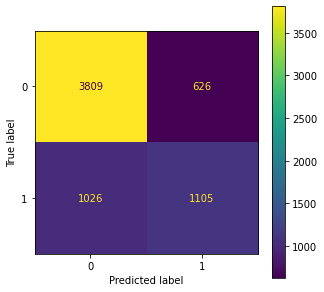

In [ ]:
# Mostrar a Matriz de Confusão 
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(knn, X_test, y_test, ax=ax, values_format='d');

## Criação da árvore de decisão e testes 

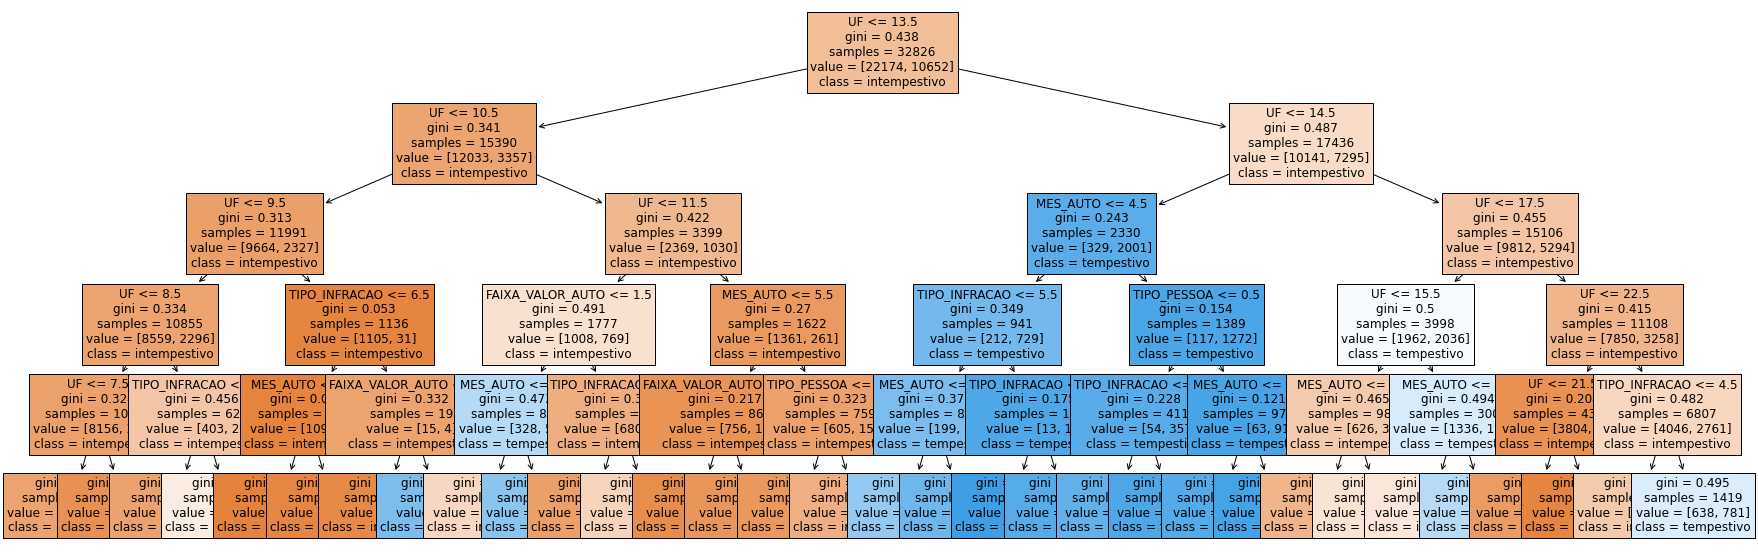

In [ ]:
# Criar árvore de decisão e plotar a árvore (plot_tree) profundidade máxima - 5

from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(max_depth=5).fit(X, y)


plt.figure(figsize=(30,10))
plot_tree(clf, filled=True, fontsize=12, feature_names=X.columns, class_names=['intempestivo', 'tempestivo'])
plt.show()

In [ ]:
# Treinar e mostrar desempenho (score) Árvore de decisão para níveis 3, 4 e 5
resultados = []
for nivel in [3,4,5]:
  clf = DecisionTreeClassifier(max_depth=nivel)
  clf.fit(X_train, y_train)
  resultados.append(clf.score(X_test, y_test))
print (resultados)

[0.7261650929028328, 0.7421565641181845, 0.7488577520560463]


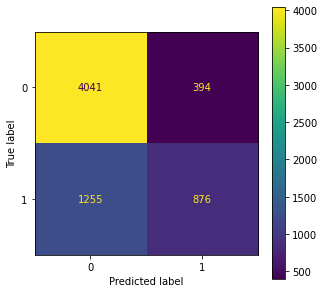

In [ ]:
# Mostrar a Matriz de Confusão 
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(clf, X_test, y_test, ax=ax, values_format='d');

Feature: 0, Score: 0.00339 TIPO_PESSOA
Feature: 1, Score: 0.87979 UF
Feature: 2, Score: 0.04094 TIPO_INFRACAO
Feature: 3, Score: 0.04078 MES_AUTO
Feature: 4, Score: 0.03510 FAIXA_VALOR_AUTO


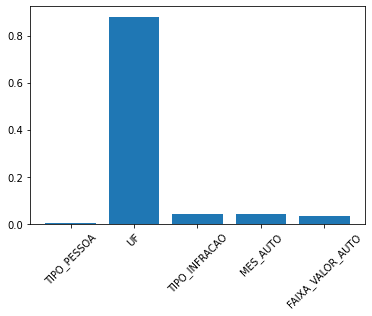

In [ ]:
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v), X.columns[i])
# plot feature importance
plt.xticks(rotation=45)
plt.bar([x for x in range(len(importance))], importance, tick_label=X.columns)

plt.show();

In [ ]:
# Visualizar com dtreeviz

from sklearn import tree
from dtreeviz.trees import dtreeviz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


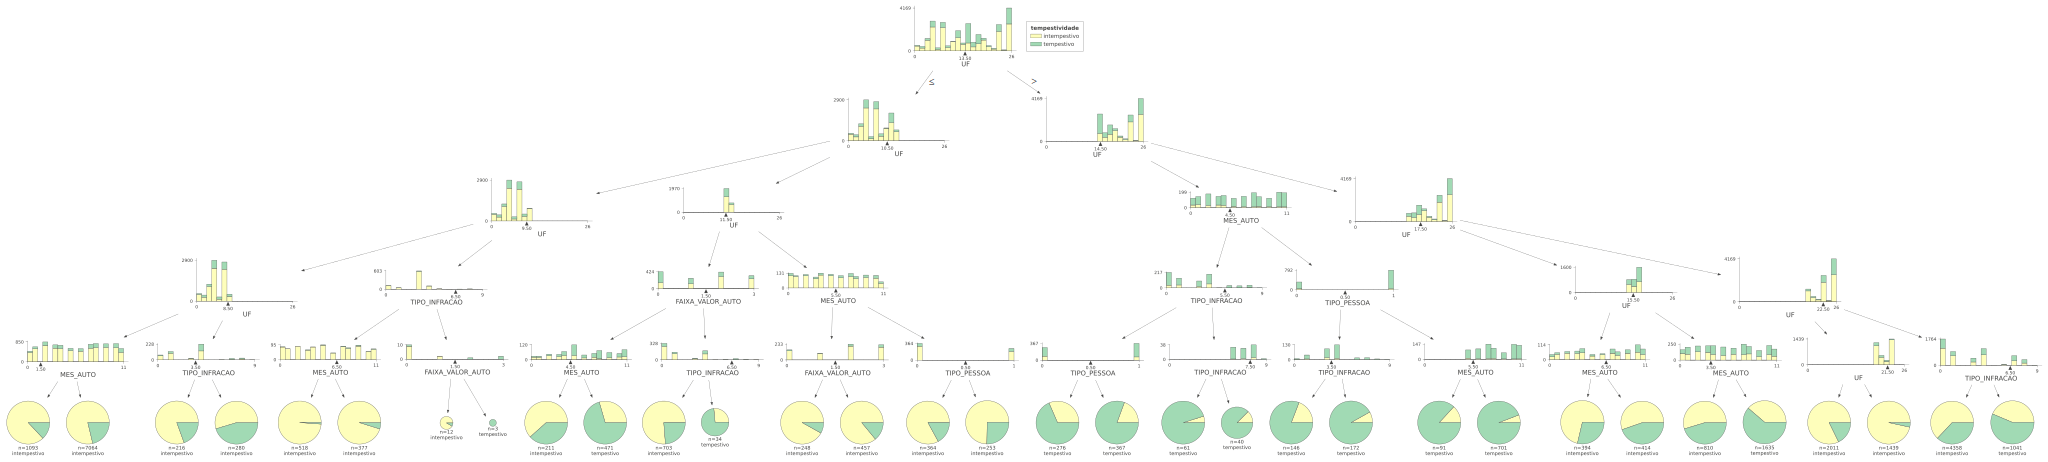

In [ ]:
# somente dados de treino
dtreeviz(clf,
               X_train,
               y_train,
               target_name='tempestividade',
               feature_names=X_train.columns,
               class_names=["intempestivo", "tempestivo"]) 

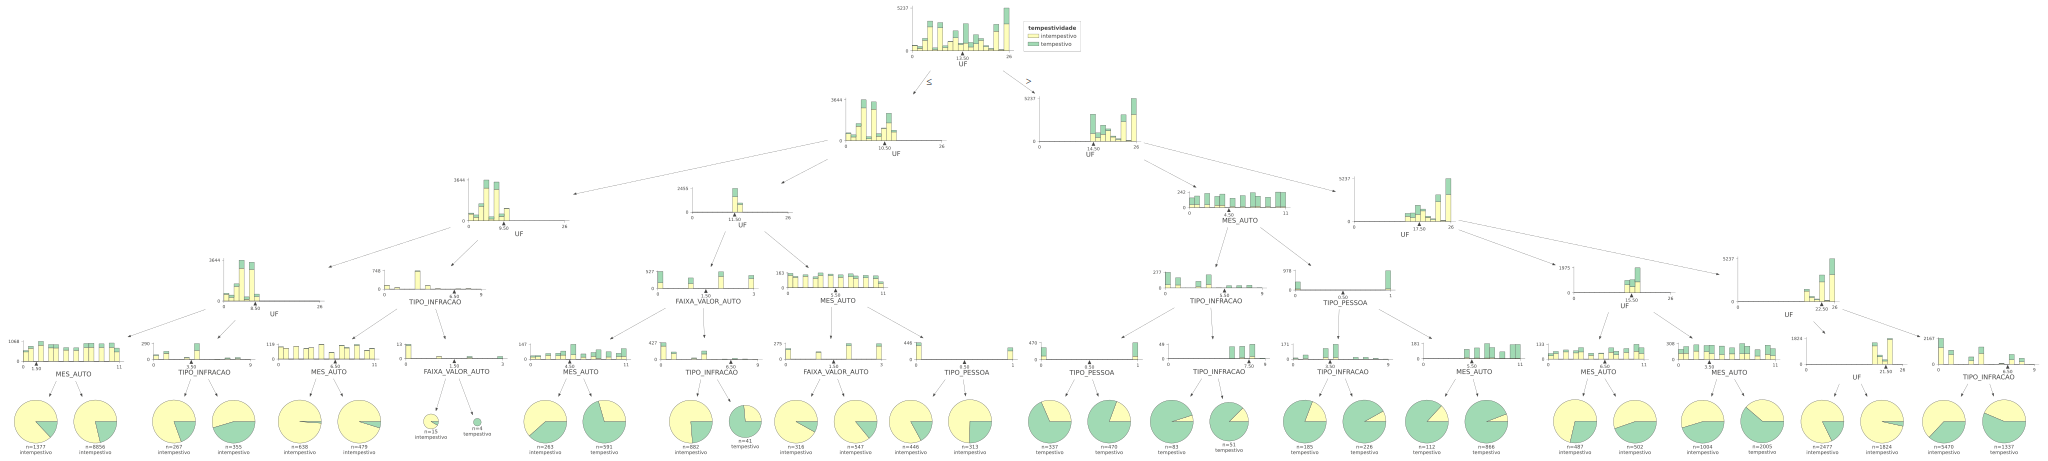

In [ ]:
# com todos os dados
dtreeviz(clf,
               X,
               y,
               target_name='tempestividade',
               feature_names=X.columns,
               class_names=["intempestivo", "tempestivo"]) 

In [ ]:
# Treinar e mostrar desempenho (score) Random Forest

rf_class = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_class.fit(X_train,y_train)
rf_class.score(X_test, y_test)

0.7400243679561377

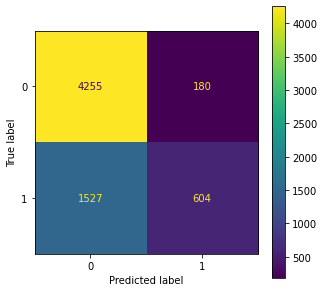

In [ ]:
# Mostrar a Matriz de Confusão 
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(rf_class, X_test, y_test, ax=ax, values_format='d');

Feature: 0, Score: 0.06877 TIPO_PESSOA
Feature: 1, Score: 0.74867 UF
Feature: 2, Score: 0.08099 TIPO_INFRACAO
Feature: 3, Score: 0.07708 MES_AUTO
Feature: 4, Score: 0.02448 FAIXA_VALOR_AUTO


<BarContainer object of 5 artists>

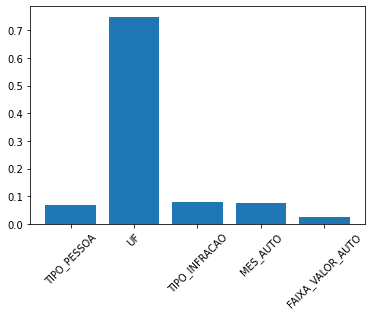

In [ ]:
importance = rf_class.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v), X.columns[i])
# plot feature importance
plt.xticks(rotation=45)
plt.bar([x for x in range(len(importance))], importance, tick_label=X.columns)

Teste com XGBoost

In [ ]:
from xgboost import XGBClassifier

model_xgboost = XGBClassifier()
model_xgboost.fit(X_train, y_train)
model_xgboost.score(X_test, y_test)

0.7484008528784648

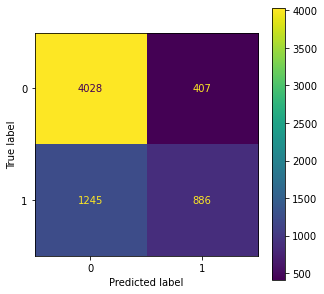

In [ ]:
# Mostrar a Matriz de Confusão 
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(model_xgboost, X_test, y_test, ax=ax, values_format='d');

Feature: 0, Score: 0.15865 TIPO_PESSOA
Feature: 1, Score: 0.50297 UF
Feature: 2, Score: 0.11871 TIPO_INFRACAO
Feature: 3, Score: 0.13353 MES_AUTO
Feature: 4, Score: 0.08614 FAIXA_VALOR_AUTO


<BarContainer object of 5 artists>

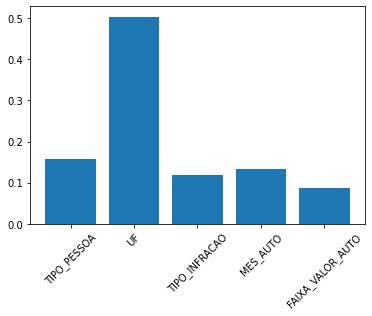

In [ ]:
importance = model_xgboost.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v), X.columns[i])
# plot feature importance
plt.xticks(rotation=45)
plt.bar([x for x in range(len(importance))], importance, tick_label=X.columns)

### Grid search com cross-validation usando KNN

In [ ]:
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
# example of grid searching key hyperparametres for KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# n_neighbors:
# Number of neighbors to use by default=5 for kneighbors queries.
#
# weights:
# Weight function used in prediction (default=’uniform)
# Possible values:
# ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
# ‘distance’ : weight points by the inverse of their distance. in this case, 
#              closer neighbors of a query point will have a greater influence than 
#              neighbors which are further away.
#
# Metrics:
# “euclidean” - EuclideanDistance - sqrt(sum((x - y)^2))
# “manhattan” - ManhattanDistance - sum(|x - y|)

# define modelos and parâmetros
model = KNeighborsClassifier()
n_neighbors = range(5, 10, 15)
weights = ['uniform', 'distance']
metric = ['None','euclidean', 'manhattan']


In [ ]:
# define a grade de parâmetros
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
grid

{'metric': ['euclidean', 'manhattan'],
 'n_neighbors': range(10, 15),
 'weights': ['uniform', 'distance']}

In [ ]:
# define o cross-validation
cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=1)
# Define gridsearch e seus parâmetros
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='balanced_accuracy',error_score=0)
# Executa o grid_search
grid_result = grid_search.fit(X, y)


In [ ]:
# Mostra o Resumo dos resultados
# Mostra o resultado do melhor modelo e seus parâmetros
print('Resumo dos resultados do GridSearchCV:')
print(f"Best: {round(grid_result.best_score_,5)} using {grid_result.best_params_}")
# recupera os valores das médias, std e parâmetros para impressão
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# Loop para impressão dos resultados
for mean, stdev, param in zip(means, stds, params):
    print(f"{round(mean,4)} ({round(stdev,4)}) with: {param}")
    # Best: 0.69348 using {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'distance'}
    # pior do qu eo KNN "puro"

Resumo dos resultados do GridSearchCV:
Best: 0.68706 using {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
0.6608 (0.0034) with: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
0.6774 (0.0059) with: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
0.675 (0.0039) with: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
0.6833 (0.0076) with: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
0.6654 (0.0059) with: {'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'uniform'}
0.6816 (0.0072) with: {'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'distance'}
0.6753 (0.0083) with: {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'uniform'}
0.687 (0.0096) with: {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'distance'}
0.6652 (0.007) with: {'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'uniform'}
0.684 (0.0104) with: {'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'distance'}
0.66

### Grid search com cross-validation usando Random Forrest

In [ ]:
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
# example of grid searching key hyperparametres for KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV



In [ ]:
# define modelos e parâmetros
model = RandomForestClassifier()
n_estimators = [120, 300]
max_depth = [5, 8,'None']
min_samples_split = [1, 2, 5]
min_samples_leaf = [1, 2, 5]
max_features = ['log2', 'None']


In [ ]:
# define a grade de parâmetros
grid = dict(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,max_features=max_features)
grid

{'max_depth': [5, 8, 'None'],
 'max_features': ['log2', 'None'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [1, 2, 5],
 'n_estimators': [120, 300]}

In [ ]:
# define o cross-validation
cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=1)
# Define gridsearch e seus parâmetros
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='balanced_accuracy',error_score=0)
# Executa o grid_search
grid_result = grid_search.fit(X, y)


In [ ]:
# Mostra o Resumo dos resultados
# Mostra o resultado do melhor modelo e seus parâmetros
print('Resumo dos resultados do GridSearchCV:')
print(f"Best: {round(grid_result.best_score_,5)} using {grid_result.best_params_}")
# recupera os valores das médias, std e parâmetros para impressão
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# Loop para impressão dos resultados
for mean, stdev, param in zip(means, stds, params):
    print(f"{round(mean,4)} ({round(stdev,4)}) with: {param}")

    # Best: 0.66387 using {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
    # Pior do que o gridsearch/cv com KNN acima

Resumo dos resultados do GridSearchCV:
Best: 0.66402 using {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 120}
0.0 (0.0) with: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 120}
0.0 (0.0) with: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 300}
0.6257 (0.0065) with: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}
0.6267 (0.0063) with: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
0.6266 (0.0064) with: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 120}
0.6268 (0.0071) with: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
0.0 (0.0) with: {'max_depth': 5, 'max_features': 'log2', '

# Grid search com cross-validation usando XGBoost

In [ ]:
# define modelo and parâmetros
model = XGBClassifier()

n_estimators = [50, 100]
learning_rate = [0.01, 0.1]
max_depth = range(3, 6)
colsample_bytree = [i/10.0 for i in range(1, 2)]
gamma = [i/10.0 for i in range(2)]

In [ ]:
# define a grade de parâmetros
grid = dict(n_estimators=n_estimators,learning_rate=learning_rate,max_depth=max_depth,colsample_bytree=colsample_bytree,gamma=gamma)
grid

{'colsample_bytree': [0.1],
 'gamma': [0.0, 0.1],
 'learning_rate': [0.01, 0.1],
 'max_depth': range(3, 6),
 'n_estimators': [50, 100]}

In [ ]:
# define o cross-validation
cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=1)
# Define gridsearch e seus parâmetros
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='balanced_accuracy',error_score=0)
# Executa o grid_search
grid_result = grid_search.fit(X, y)

In [ ]:
# Mostra o Resumo dos resultados
# Mostra o resultado do melhor modelo e seus parâmetros
print('Resumo dos resultados do GridSearchCV:')
print(f"Best: {round(grid_result.best_score_,5)} using {grid_result.best_params_}")
# recupera os valores das médias, std e parâmetros para impressão
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# Loop para impressão dos resultados
for mean, stdev, param in zip(means, stds, params):
    print(f"{round(mean,4)} ({round(stdev,4)}) with: {param}")

   # Best: 0.65742 using {'colsample_bytree': 0.1, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Resumo dos resultados do GridSearchCV:
Best: 0.65742 using {'colsample_bytree': 0.1, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
0.5092 (0.0033) with: {'colsample_bytree': 0.1, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.5213 (0.0079) with: {'colsample_bytree': 0.1, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.5097 (0.0016) with: {'colsample_bytree': 0.1, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50}
0.5223 (0.0039) with: {'colsample_bytree': 0.1, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
0.5097 (0.0016) with: {'colsample_bytree': 0.1, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.5225 (0.004) with: {'colsample_bytree': 0.1, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
0.6128 (0.0062) with: {'colsample_bytree': 0.1, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators'

### 2a rodada de testes codificação das variáveis independentes com one-hot encoding - para comparar desempenho

In [ ]:
# Antes de dividir os dados entre treinamento e teste, codificar tudo, pois são todas categóricas
X = pd.get_dummies(X_base)


In [ ]:
X.head().T

,397,735,736,737,1619
TIPO_PESSOA_Pessoa Física,0,0,0,0,0
TIPO_PESSOA_Pessoa Jurídica,1,1,1,1,1
UF_AC,0,0,0,0,0
UF_AL,0,0,0,0,0
UF_AM,0,0,0,0,0
UF_AP,0,0,0,0,0
UF_BA,0,0,0,0,0
UF_CE,0,0,0,0,0
UF_DF,0,0,0,0,0
UF_ES,0,0,0,0,0


In [ ]:
# Dividir o dataset entre treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, stratify = y)
print('Dimensões de X_train = ', X_train.shape)
print('Dimensões de X_test = ', X_test.shape)

Dimensões de X_train =  (26260, 55)
Dimensões de X_test =  (6566, 55)


In [ ]:
print('Amostras de treino= ', y_train.shape)
y_train.value_counts()

Amostras de treino=  (26260,)


0    17739
1     8521
Name: TEMPESTIVIDADE, dtype: int64

In [ ]:
print('Amostras de teste= ', y_test.shape)
y_test.value_counts()

Amostras de teste=  (6566,)


0    4435
1    2131
Name: TEMPESTIVIDADE, dtype: int64

## Treinamento do Modelo - Regressão Logística

In [ ]:
# Instanciar modelo de regressão logística
reg_log = LogisticRegression(max_iter=1000)

In [ ]:
# Treinar o modelo
reg_log.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Verificar a acurácia do modelo (.score)
reg_log.score(X_test, y_test)
# melhorou em relação ao modelo com dados labelencoded = 0.6727078891257996


0.7480962534267438

In [ ]:
# Verificar o f1_score do modelo, quando as classes estão desbalenceadas
metrics.f1_score(y_test, reg_log.predict(X_test), average='weighted')

0.7318268540156374

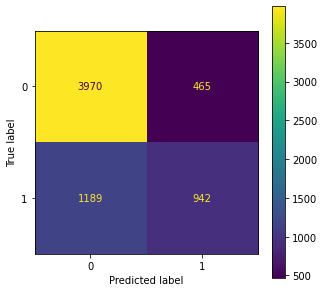

In [ ]:
# Mostrar a Matriz de Confusão 
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(reg_log, X_test, y_test, ax=ax, values_format='d');

## Treinamento do Modelo - KNN

In [ ]:
# Importar o modelo knn
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Instanciar modelo de regressão logística
knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
# paramentrso
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
# Treinar o modelo
knn.fit(X_train, y_train)


KNeighborsClassifier()

In [ ]:
# Verificar a acurácia do modelo (.score)
knn.score(X_test, y_test)
# piorou um pouquinho em relação ao modelo com dados labelencoded = 0.7484008528784648

0.7375875723423698

In [ ]:
# Verificar o f1_score do modelo, quando as classes estão desbalenceadas
metrics.f1_score(y_test, knn.predict(X_test), average='weighted')

0.7305306072524052

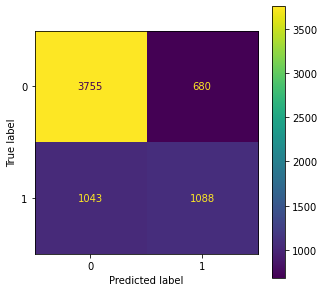

In [ ]:
# Mostrar a Matriz de Confusão 
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(knn, X_test, y_test, ax=ax, values_format='d');

# Treinamento do modelo - Árvore de Decisão

In [ ]:
# Treinar e mostrar desempenho (score) Árvore de decisão para níveis 3, 4 e 5
resultados = []
for nivel in [3,4,5]:
  clf = DecisionTreeClassifier(max_depth=nivel)
  clf.fit(X_train, y_train)
  resultados.append(clf.score(X_test, y_test))
print (resultados)

# Resultados com label encoded foram semelhantes: [0.7261650929028328, 0.7421565641181845, 0.7488577520560463]

[0.7339323789217179, 0.7388059701492538, 0.7439841608285105]


In [ ]:
# Verificar o f1_score do modelo, quando as classes estão desbalenceadas
metrics.f1_score(y_test, knn.predict(X_test), average='weighted')

0.7305306072524052

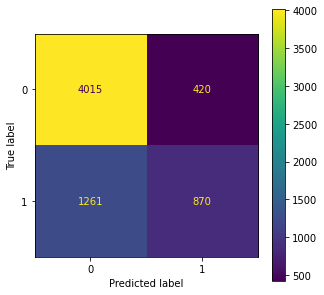

In [ ]:
# Mostrar a Matriz de Confusão 
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(clf, X_test, y_test, ax=ax, values_format='d');

Feature: 0, Score: 0.00000 TIPO_PESSOA_Pessoa Física
Feature: 1, Score: 0.00797 TIPO_PESSOA_Pessoa Jurídica
Feature: 2, Score: 0.00000 UF_AC
Feature: 3, Score: 0.00000 UF_AL
Feature: 4, Score: 0.00000 UF_AM
Feature: 5, Score: 0.00000 UF_AP
Feature: 6, Score: 0.00000 UF_BA
Feature: 7, Score: 0.00000 UF_CE
Feature: 8, Score: 0.00000 UF_DF
Feature: 9, Score: 0.00000 UF_ES
Feature: 10, Score: 0.00000 UF_GO
Feature: 11, Score: 0.00000 UF_MA
Feature: 12, Score: 0.00000 UF_MG
Feature: 13, Score: 0.00861 UF_MS
Feature: 14, Score: 0.00000 UF_MT
Feature: 15, Score: 0.00000 UF_PA
Feature: 16, Score: 0.54807 UF_PB
Feature: 17, Score: 0.00000 UF_PE
Feature: 18, Score: 0.06833 UF_PI
Feature: 19, Score: 0.13588 UF_PR
Feature: 20, Score: 0.00000 UF_RJ
Feature: 21, Score: 0.00000 UF_RN
Feature: 22, Score: 0.00000 UF_RO
Feature: 23, Score: 0.00000 UF_RR
Feature: 24, Score: 0.00000 UF_RS
Feature: 25, Score: 0.09626 UF_SC
Feature: 26, Score: 0.00000 UF_SE
Feature: 27, Score: 0.00000 UF_SP
Feature: 28, Sco

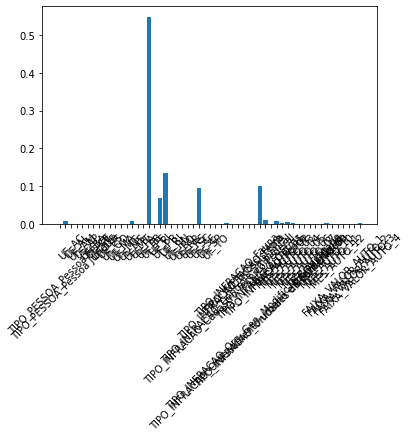

In [ ]:
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v), X.columns[i])
# plot feature importance
plt.xticks(rotation=45)
plt.bar([x for x in range(len(importance))], importance, tick_label=X.columns)
plt.show();

# destaque para UF_PB


# Treinamento do modelo - Random Forest

In [ ]:
# Treinar e mostrar desempenho (score) Random Forest

rf_class = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_class.fit(X_train,y_train)
rf_class.score(X_test, y_test)

# com dados labelencoded foi melhor = 0.7400243679561377

0.7299725860493451

In [ ]:
# Verificar o f1_score do modelo, quando as classes estão desbalenceadas
metrics.f1_score(y_test, rf_class.predict(X_test), average='weighted')

0.6688197421136911

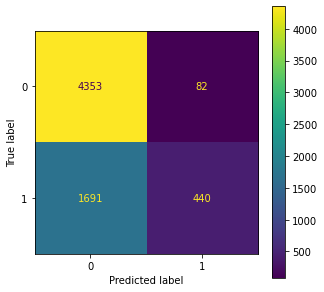

In [ ]:
# Mostrar a Matriz de Confusão 
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(rf_class, X_test, y_test, ax=ax, values_format='d');

Feature: 0, Score: 0.01974 TIPO_PESSOA_Pessoa Física
Feature: 1, Score: 0.02282 TIPO_PESSOA_Pessoa Jurídica
Feature: 2, Score: 0.00000 UF_AC
Feature: 3, Score: 0.00477 UF_AL
Feature: 4, Score: 0.00005 UF_AM
Feature: 5, Score: 0.00048 UF_AP
Feature: 6, Score: 0.01761 UF_BA
Feature: 7, Score: 0.02665 UF_CE
Feature: 8, Score: 0.00396 UF_DF
Feature: 9, Score: 0.00399 UF_ES
Feature: 10, Score: 0.02126 UF_GO
Feature: 11, Score: 0.00011 UF_MA
Feature: 12, Score: 0.05410 UF_MG
Feature: 13, Score: 0.00437 UF_MS
Feature: 14, Score: 0.00578 UF_MT
Feature: 15, Score: 0.00316 UF_PA
Feature: 16, Score: 0.37163 UF_PB
Feature: 17, Score: 0.00067 UF_PE
Feature: 18, Score: 0.02215 UF_PI
Feature: 19, Score: 0.09214 UF_PR
Feature: 20, Score: 0.01399 UF_RJ
Feature: 21, Score: 0.00104 UF_RN
Feature: 22, Score: 0.00010 UF_RO
Feature: 23, Score: 0.00009 UF_RR
Feature: 24, Score: 0.10042 UF_RS
Feature: 25, Score: 0.04756 UF_SC
Feature: 26, Score: 0.00000 UF_SE
Feature: 27, Score: 0.01459 UF_SP
Feature: 28, Sco

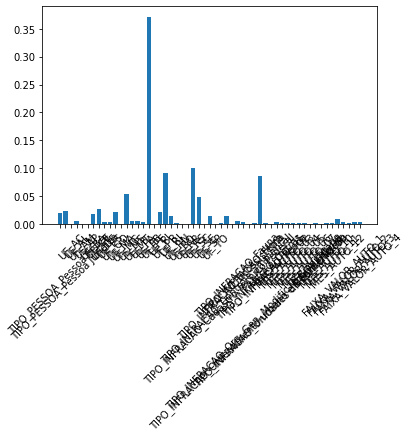

In [ ]:
importance = rf_class.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v), X.columns[i])
# plot feature importance
plt.xticks(rotation=45)
plt.bar([x for x in range(len(importance))], importance, tick_label=X.columns)
plt.show();

Treinamneto do modelo - XGBoost

In [ ]:
from xgboost import XGBClassifier

model_xgboost = XGBClassifier()
model_xgboost.fit(X_train, y_train)
model_xgboost.score(X_test, y_test)

# com dados labelencoded foi pior = 0.74840085287846487

0.7508376484922327

In [ ]:
model_xgboost.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
# Verificar o f1_score do modelo, quando as classes estão desbalenceadas
metrics.f1_score(y_test, model_xgboost.predict(X_test), average='weighted')

0.7275233429054172

Feature: 0, Score: 0.00688 TIPO_PESSOA_Pessoa Física
Feature: 1, Score: 0.00000 TIPO_PESSOA_Pessoa Jurídica
Feature: 2, Score: 0.00000 UF_AC
Feature: 3, Score: 0.01559 UF_AL
Feature: 4, Score: 0.00371 UF_AM
Feature: 5, Score: 0.00852 UF_AP
Feature: 6, Score: 0.01514 UF_BA
Feature: 7, Score: 0.02275 UF_CE
Feature: 8, Score: 0.02171 UF_DF
Feature: 9, Score: 0.01200 UF_ES
Feature: 10, Score: 0.02216 UF_GO
Feature: 11, Score: 0.00902 UF_MA
Feature: 12, Score: 0.04525 UF_MG
Feature: 13, Score: 0.03499 UF_MS
Feature: 14, Score: 0.01387 UF_MT
Feature: 15, Score: 0.01225 UF_PA
Feature: 16, Score: 0.24858 UF_PB
Feature: 17, Score: 0.00834 UF_PE
Feature: 18, Score: 0.05242 UF_PI
Feature: 19, Score: 0.08921 UF_PR
Feature: 20, Score: 0.01959 UF_RJ
Feature: 21, Score: 0.00957 UF_RN
Feature: 22, Score: 0.00654 UF_RO
Feature: 23, Score: 0.00461 UF_RR
Feature: 24, Score: 0.06207 UF_RS
Feature: 25, Score: 0.06032 UF_SC
Feature: 26, Score: 0.00000 UF_SE
Feature: 27, Score: 0.03552 UF_SP
Feature: 28, Sco

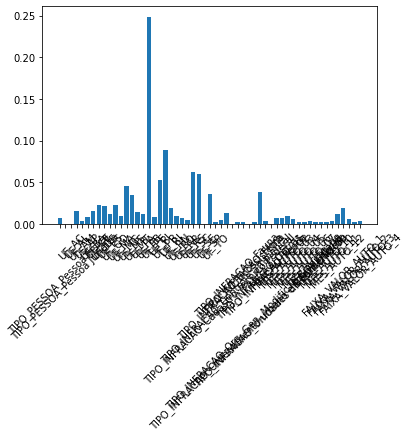

In [ ]:
importance = model_xgboost.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v), X.columns[i])
# plot feature importance
plt.xticks(rotation=45)
plt.bar([x for x in range(len(importance))], importance, tick_label=X.columns)
plt.show();

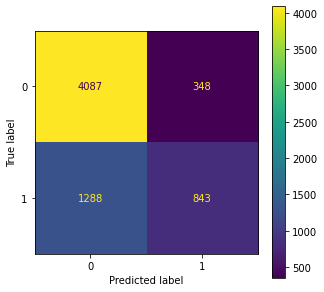

In [ ]:
# Mostrar a Matriz de Confusão 
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(model_xgboost, X_test, y_test, ax=ax, values_format='d');

### Grid search com cross-validation usando KNN

In [ ]:
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
# example of grid searching key hyperparametres for KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# n_neighbors:
# Number of neighbors to use by default=5 for kneighbors queries.
#
# weights:
# Weight function used in prediction (default=’uniform)
# Possible values:
# ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
# ‘distance’ : weight points by the inverse of their distance. in this case, 
#              closer neighbors of a query point will have a greater influence than 
#              neighbors which are further away.
#
# Metrics:
# “euclidean” - EuclideanDistance - sqrt(sum((x - y)^2))
# “manhattan” - ManhattanDistance - sum(|x - y|)


# default parameters

#{'algorithm': 'auto',
# 'leaf_size': 30,
# 'metric': 'minkowski',
# 'metric_params': None,
# 'n_jobs': None,
# 'n_neighbors': 5,
# 'p': 2,
# 'weights': 'uniform'}

# define modelos and parâmetros
model = KNeighborsClassifier()
n_neighbors = range(5, 10, 15)
weights = ['uniform', 'distance']
metric = ['None', 'euclidean', 'manhattan']


In [ ]:
# define a grade de parâmetros
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
grid

{'metric': ['None', 'euclidean', 'manhattan'],
 'n_neighbors': range(5, 10, 15),
 'weights': ['uniform', 'distance']}

In [ ]:
# define o cross-validation
cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=1)
# Define gridsearch e seus parâmetros
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='balanced_accuracy',error_score=0)
# Executa o grid_search
grid_result = grid_search.fit(X, y)


In [ ]:
# Mostra o Resumo dos resultados
# Mostra o resultado do melhor modelo e seus parâmetros
print('Resumo dos resultados do GridSearchCV:')

print(f"Best: {round(grid_result.best_score_,5)} using {grid_result.best_params_}")
# recupera os valores das médias, std e parâmetros para impressão

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# Loop para impressão dos resultados
for mean, stdev, param in zip(means, stds, params):
    print(f"{round(mean,4)} ({round(stdev,4)}) with: {param}")


# resultado atual: Best: 0.75684 using {'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'distance'}
# O melhor resultado com dados labelencoded, que rodou mais rápido, foi = Best: 0.75474 using {'metric': 'manhattan', 'n_neighbors': 14, 'weights': 'distance'}
# Então o resultado agora com onehotencode foi um pouquinho melhor

Resumo dos resultados do GridSearchCV:
Best: 0.69033 using {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.0 (0.0) with: {'metric': 'None', 'n_neighbors': 5, 'weights': 'uniform'}
0.0 (0.0) with: {'metric': 'None', 'n_neighbors': 5, 'weights': 'distance'}
0.6868 (0.0066) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.6903 (0.0076) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.6868 (0.0066) with: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
0.6903 (0.0076) with: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


### Grid search com cross-validation usando Random Forest

In [ ]:
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
# example of grid searching key hyperparametres for KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# default parameters
#{'bootstrap': True,
 #'ccp_alpha': 0.0,
#'class_weight': None,
 #'criterion': 'gini',
# 'max_depth': None,
# 'max_features': 'auto',
# 'max_leaf_nodes': None,
# 'max_samples': None,
# 'min_impurity_decrease': 0.0,
# 'min_samples_leaf': 1,
# 'min_samples_split': 2,
# 'min_weight_fraction_leaf': 0.0,
# 'n_estimators': 100,
 #'n_jobs': None,
# 'oob_score': False,
# 'random_state': None,
# 'verbose': 0,
# 'warm_start': False}

# parametros do teste sem CV
#(n_estimators=100, max_depth=5, random_state=42)

In [ ]:
# define modelos e parâmetros
model = RandomForestClassifier()
n_estimators = [100,300]
max_depth = [5, 8,'None']
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
max_features = ['log2', 'None']


In [ ]:
# define a grade de parâmetros
grid = dict(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,max_features=max_features)
grid


{'max_depth': [5, 8, 'None'],
 'max_features': ['log2', 'None'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5],
 'n_estimators': [100, 300]}

In [ ]:
# define o cross-validation
cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=1)
# Define gridsearch e seus parâmetros
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='balanced_accuracy',error_score=0)
# Executa o grid_search
grid_result = grid_search.fit(X, y)


In [ ]:
# Mostra o Resumo dos resultados
# Mostra o resultado do melhor modelo e seus parâmetros
print('Resumo dos resultados do GridSearchCV:')
print(f"Best: {round(grid_result.best_score_,5)} using {grid_result.best_params_}")
# recupera os valores das médias, std e parâmetros para impressão
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# Loop para impressão dos resultados
for mean, stdev, param in zip(means, stds, params):
    print(f"{round(mean,4)} ({round(stdev,4)}) with: {param}")


    # atual Best: 0.66358 using {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 120}

    # com labelencoded => Best: 0.66387 using {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
    # Pior do que o gridsearch/cv com KNN acima

Resumo dos resultados do GridSearchCV:
Best: 0.60101 using {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
0.5797 (0.0092) with: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.576 (0.0085) with: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
0.5701 (0.0107) with: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.5812 (0.0081) with: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
0.5794 (0.0101) with: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.582 (0.0083) with: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
0.5728 (0.0218) with: {'max_depth': 5, 'max_feat

# Grid search com cross-validation usando XGBoost

In [ ]:
X.head()

,TIPO_PESSOA_Pessoa Física,TIPO_PESSOA_Pessoa Jurídica,UF_AC,UF_AL,UF_AM,UF_AP,UF_BA,UF_CE,UF_DF,UF_ES,UF_GO,UF_MA,UF_MG,UF_MS,UF_MT,UF_PA,UF_PB,UF_PE,UF_PI,UF_PR,UF_RJ,UF_RN,UF_RO,UF_RR,UF_RS,UF_SC,UF_SE,UF_SP,UF_TO,TIPO_INFRACAO_Cadastro Técnico Federal,TIPO_INFRACAO_Controle ambiental,TIPO_INFRACAO_Ecossistema,TIPO_INFRACAO_Fauna,TIPO_INFRACAO_Flora,TIPO_INFRACAO_Ordenamento urbano e Contr. patrim.,TIPO_INFRACAO_Org. Gen. Modific. e Biopirataria,TIPO_INFRACAO_Outras,TIPO_INFRACAO_Pesca,TIPO_INFRACAO_Unidades de conservação,MES_AUTO_01,MES_AUTO_02,MES_AUTO_03,MES_AUTO_04,MES_AUTO_05,MES_AUTO_06,MES_AUTO_07,MES_AUTO_08,MES_AUTO_09,MES_AUTO_10,MES_AUTO_11,MES_AUTO_12,FAIXA_VALOR_AUTO_1,FAIXA_VALOR_AUTO_2,FAIXA_VALOR_AUTO_3,FAIXA_VALOR_AUTO_4
397,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
735,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
736,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
737,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1619,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [ ]:

##model = XGBClassifier()

##n_estimators = [50, 100]
#learning_rate = [0.01, 0.1]
#max_depth = range(3, 6)
#colsample_bytree = [i/10.0 for i in range(1, 2)]
#gamma = [i/10.0 for i in range(2)]

In [ ]:
# define modelo and parâmetros
model = XGBClassifier()
n_estimators = [50, 100]
learning_rate = [0.01, 0.1]
max_depth = range(3, 6)
colsample_bytree = [1, 2]
gamma = [0,1]

In [ ]:
# define a grade de parâmetros
grid = dict(n_estimators=n_estimators,learning_rate=learning_rate,max_depth=max_depth,colsample_bytree=colsample_bytree,gamma=gamma)
grid

{'colsample_bytree': [1, 2],
 'gamma': [0, 1],
 'learning_rate': [0.01, 0.1],
 'max_depth': range(3, 6),
 'n_estimators': [50, 100]}

In [ ]:
# define o cross-validation
cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=1)
# Define gridsearch e seus parâmetros
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='balanced_accuracy',error_score=0)
# Executa o grid_search
grid_result = grid_search.fit(X, y)

In [ ]:
# Mostra o Resumo dos resultados
# Mostra o resultado do melhor modelo e seus parâmetros
print('Resumo dos resultados do GridSearchCV:')
print(f"Best: {round(grid_result.best_score_,5)} using {grid_result.best_params_}")
# recupera os valores das médias, std e parâmetros para impressão
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# Loop para impressão dos resultados
for mean, stdev, param in zip(means, stds, params):
    print(f"{round(mean,4)} ({round(stdev,4)}) with: {param}")

    # Atual => Best: 0.62561 using {'colsample_bytree': 0.1, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

   # com label encoded Best: 0.65742 using {'colsample_bytree': 0.1, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Resumo dos resultados do GridSearchCV:
Best: 0.68183 using {'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
0.6028 (0.0113) with: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.5925 (0.0034) with: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.6258 (0.0068) with: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50}
0.616 (0.01) with: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
0.6399 (0.0051) with: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.6366 (0.0051) with: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
0.6319 (0.01) with: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0.6633 (0.005) with: {'colsamp

### 3a rodada de testes codificação das variáveis independentes com Catboostencoding - para comparar desempenho

In [ ]:
!pip install CatBoost

     |████████████████████████████████| 76.3 MB 54 kB/s 


Fim do caderno